## Data Exploration - Spaceship Titanic Kaggle Competition

In [ ]:
pip install altair

In [25]:
import boto3
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
pd.set_option('display.max_columns', 50)

In [26]:
## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

## Using pandas to read the data files

file_key = 'titanic_train.csv'
file_key2 = 'titanic_test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream)
test = pd.read_csv(file_content_stream2)

train.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Exploration

In [10]:
train['Transported'] = np.where(train['Transported'] == False, 0, 1)

#### Home Planet

In [27]:
alt.Chart(train).mark_bar().encode(
  x='count(HomePlanet)',
  y='HomePlanet',
  color='HomePlanet'
)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

In [18]:
## Proportion of Home Planet

plt.bar()
#plt.xticks(train['HomePlanet'].values, )




# # Make a random dataset:
# height = [3, 12, 5, 18, 45]
bars = (train['HomePlanet'].unique())
y_pos = np.arange(len(bars))

# # Create bars
# plt.bar(y_pos, height)

# # Create names on the x-axis
# plt.xticks(y_pos, bars)

# # Show graphic
plt.show()

TypeError: bar() missing 1 required positional argument: 'height'

In [23]:
## Proportion of Transported people by Home Planet:

print('Home planets of transported:', train.groupby('HomePlanet')['Transported'].sum() / train['Transported'].sum())

print('\nTransported proportions by group:', train.groupby('HomePlanet')['Transported'].sum() / train.groupby('HomePlanet')['Transported'].count())

Home planets of transported: HomePlanet
Earth     0.445637
Europa    0.320694
Mars      0.210142
Name: Transported, dtype: float64

Transported proportions by group: HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64


In [26]:
## Proportion of Transported people by CryoSleep:

print('CryoSleep status of transported:', train.groupby('CryoSleep')['Transported'].sum() / train['Transported'].sum())

print('\nTransported proportions by CryoSleep status:', train.groupby('CryoSleep')['Transported'].sum() / train.groupby('CryoSleep')['Transported'].count())

CryoSleep status of transported: CryoSleep
False    0.408634
True     0.567154
Name: Transported, dtype: float64

Transported proportions by CryoSleep status: CryoSleep
False    0.328921
True     0.817583
Name: Transported, dtype: float64


In [7]:
## Cabin:

print(train['Cabin'].nunique())
print(test['Cabin'].nunique())

6560
3265


In [8]:
## Destination:

print('Training Set:\n',train['Destination'].value_counts())
print('\nTesting Set:\n',test['Destination'].value_counts())

Training Set:
 TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Testing Set:
 TRAPPIST-1e      2956
55 Cancri e       841
PSO J318.5-22     388
Name: Destination, dtype: int64


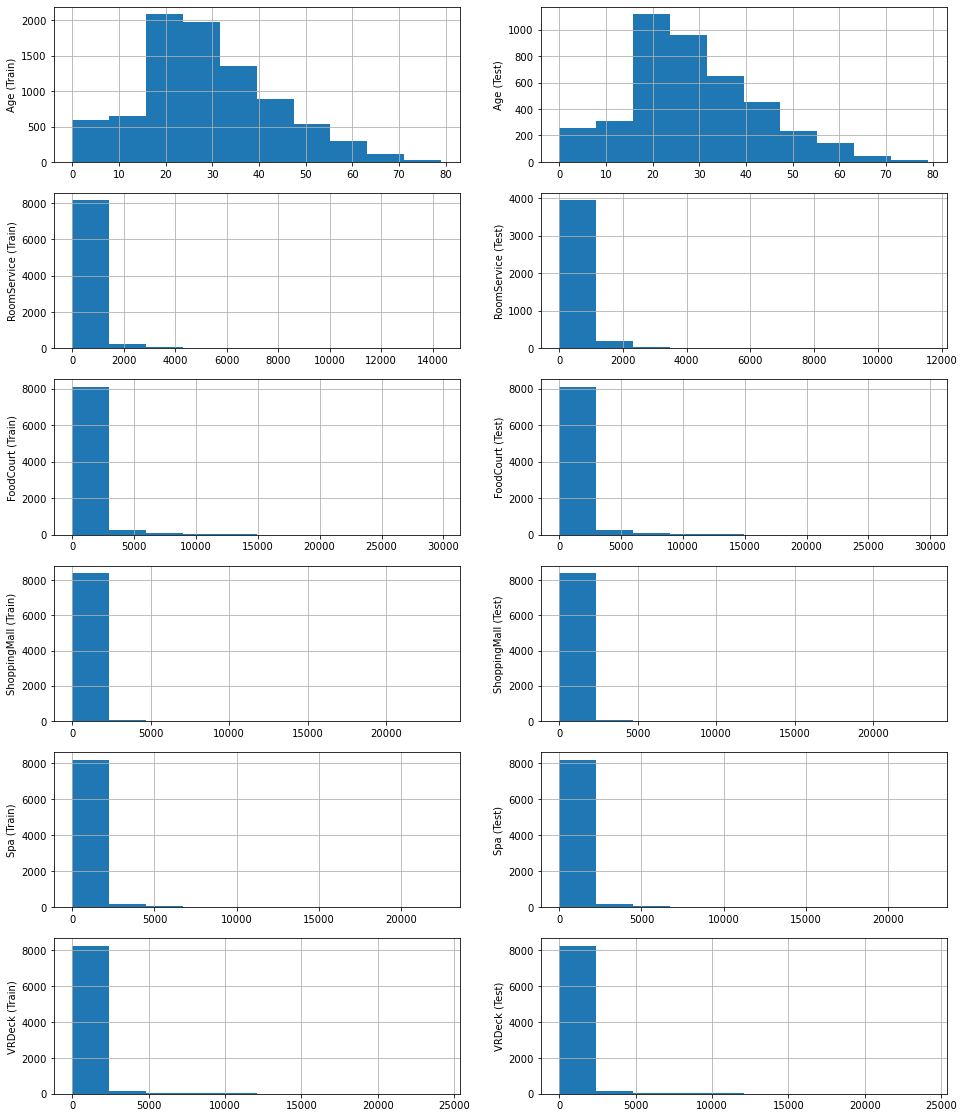

In [9]:
## Visualizing features:

## Creating a new figure
fig, axes = plt.subplots(6, 2, figsize = (16, 20))

axes[0, 0].hist([train['Age']], bins = 10)
axes[0, 0].set_ylabel('Age (Train)')
axes[0, 0].grid()

axes[0, 1].hist([test['Age']], bins = 10)
axes[0, 1].set_ylabel('Age (Test)')
axes[0, 1].grid()

axes[1, 0].hist([train['RoomService']])
axes[1, 0].set_ylabel('RoomService (Train)')
axes[1, 0].grid()

axes[1, 1].hist([test['RoomService']])
axes[1, 1].set_ylabel('RoomService (Test)')
axes[1, 1].grid()

axes[2, 0].hist([train['FoodCourt']])
axes[2, 0].set_ylabel('FoodCourt (Train)')
axes[2, 0].grid()

axes[2, 1].hist([train['FoodCourt']])
axes[2, 1].set_ylabel('FoodCourt (Test)')
axes[2, 1].grid()

axes[3, 0].hist([train['ShoppingMall']])
axes[3, 0].set_ylabel('ShoppingMall (Train)')
axes[3, 0].grid()

axes[3, 1].hist([train['ShoppingMall']])
axes[3, 1].set_ylabel('ShoppingMall (Test)')
axes[3, 1].grid()

axes[4, 0].hist([train['Spa']])
axes[4, 0].set_ylabel('Spa (Train)')
axes[4, 0].grid()

axes[4, 1].hist([train['Spa']])
axes[4, 1].set_ylabel('Spa (Test)')
axes[4, 1].grid()

axes[5, 0].hist([train['VRDeck']])
axes[5, 0].set_ylabel('VRDeck (Train)')
axes[5, 0].grid()

axes[5, 1].hist([train['VRDeck']])
axes[5, 1].set_ylabel('VRDeck (Test)')
axes[5, 1].grid()

In [10]:
## VIP:

print('Training Set:\n',train['VIP'].value_counts())
print('\nTesting Set:\n',test['VIP'].value_counts())

Training Set:
 False    8291
True      199
Name: VIP, dtype: int64

Testing Set:
 False    4110
True       74
Name: VIP, dtype: int64


In [11]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
